In [ ]:
import os
import PIL
import dlib
import matplotlib.pyplot as plt
import datetime
import numpy as np

from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

In [ ]:
!pip install tensorboardX

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 4.8 MB/s eta 0:00:00


In [ ]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split, SubsetRandomSampler
import torch.optim as optim

from tensorboardX import SummaryWriter

In [ ]:
epochs = 10
batch_size = 16

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_root = '/content/drive/MyDrive/dataset/dataset__'

In [ ]:
len(os.listdir(data_root))

12

In [ ]:
warm = pd.read_csv(os.path.join(data_root, 'mean_warm.csv'))

In [ ]:
cool = pd.read_csv(os.path.join(data_root, 'mean_cool.csv'))

In [ ]:
warm.head()

,lips_s,face_l_var,skin_avg_b,R,G,B,H,S,V,L,a,b,label
0,151.666667,0.000008,145.8,112.914310,133.965925,175.651445,9.75,105.75,165.50,139.25,141.50,145.25,fall
1,150.000000,0.000025,146.3,126.187999,147.715856,191.952797,8.25,99.50,181.00,152.50,142.75,144.50,spring
2,154.000000,0.000012,141.8,112.976115,125.444865,172.908069,5.25,107.25,157.75,127.75,144.50,140.50,spring
3,152.333333,0.000009,145.1,105.951249,125.220850,170.398417,8.75,115.50,163.75,134.25,143.00,145.00,fall
4,151.666667,0.000015,145.2,108.123511,128.183753,173.363279,8.50,115.75,167.00,136.25,143.50,145.25,spring


In [ ]:
cool.head()

,lips_s,face_l_var,skin_avg_b,R,G,B,H,S,V,L,a,b,label
0,150.000000,0.000017,135.7,146.529861,151.952035,183.768130,50.25,52.50,192.00,174.75,139.25,135.50,winter
1,148.666667,0.000015,131.7,124.505782,121.864497,154.492476,132.00,65.00,159.75,140.25,142.75,131.50,summer
2,152.666667,0.000011,137.9,133.683797,143.018812,176.591909,6.50,75.00,177.00,156.25,139.75,137.75,winter
3,149.000000,0.000013,131.2,153.055289,150.278625,182.753878,177.00,51.75,180.00,161.50,141.75,131.00,summer
4,151.666667,0.000013,141.8,114.381391,130.792897,167.393703,9.75,87.00,162.75,141.00,139.25,141.75,summer


In [ ]:
warm_ = warm.copy()
warm_['label'] = warm_['label'].apply(lambda x: 'warm')
cool_ = cool.copy()
cool_['label'] = cool_['label'].apply(lambda x: 'cool')

In [ ]:
wc = pd.concat([warm, cool])
wc['label'] = wc['label'].apply(lambda x: 0 if x == 'warm' else 1)

In [ ]:
wc.sample(frac=1, random_state=42).reset_index(drop=True)
X_train_full = wc.iloc[:, :-1]
y_train_full = wc['label']

In [ ]:
wc.head()

,lips_s,face_l_var,skin_avg_b,R,G,B,H,S,V,L,a,b,label
0,151.666667,0.000008,145.8,112.914310,133.965925,175.651445,9.75,105.75,165.50,139.25,141.50,145.25,1
1,150.000000,0.000025,146.3,126.187999,147.715856,191.952797,8.25,99.50,181.00,152.50,142.75,144.50,1
2,154.000000,0.000012,141.8,112.976115,125.444865,172.908069,5.25,107.25,157.75,127.75,144.50,140.50,1
3,152.333333,0.000009,145.1,105.951249,125.220850,170.398417,8.75,115.50,163.75,134.25,143.00,145.00,1
4,151.666667,0.000015,145.2,108.123511,128.183753,173.363279,8.50,115.75,167.00,136.25,143.50,145.25,1


In [ ]:
X_train_full.shape

(188, 12)

In [ ]:
y_train_full.shape

(188,)

In [ ]:
test_size = int(len(X_train_full) * .15)
test_size

28

In [ ]:
X_train = X_train_full[test_size:].to_numpy()
y_train = y_train_full[test_size:].to_numpy()
X_test = X_train_full[:test_size].to_numpy()
y_test = y_train_full[:test_size].to_numpy()

In [ ]:
X_train = np.copy(X_train)
mean = X_train.mean(axis=0)
X_train -= mean
std = X_train.std(axis=0)
X_train /= std

X_test = np.copy(X_test)
X_test -= mean
X_test /= std

In [ ]:
X_train

array([[ 0.73652656, -0.96802798,  0.45080635, ..., -1.52068909,
        -0.05128309,  0.35778592],
       [-0.65113218,  1.23710111,  1.50107896, ...,  1.04877878,
        -1.67208205,  1.36754808],
       [-0.5443892 ,  1.1554729 ,  0.66703895, ...,  0.20452505,
        -0.25388296,  0.59080796],
       ...,
       [ 0.09606868, -0.02417185, -0.97015071, ..., -0.3460752 ,
        -0.76038263, -1.0015093 ],
       [-1.50507601,  0.39606108, -1.54162257, ...,  1.15889883,
        -0.05128309, -1.54522738],
       [ 0.5230406 ,  0.54089991, -0.16700107, ...,  0.05769832,
         0.55651652, -0.14709516]])

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow import keras

In [ ]:
from tensorflow.keras import layers

In [ ]:
def build_model():
    model = keras.models.Sequential()
    model.add(layers.Flatten(input_shape=(X_train.shape[1],)))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
    return model

In [ ]:
k = 5
n = len(X_train)
n_val = n // k
num_epochs = 20
all_val_losses = []
all_train_losses = []
all_train_acc = []
all_val_acc = []

for i in range(k):
  print('processing fold #', i)
  val_data = X_train[i * n_val: (i + 1) * n_val]
  val_targets = y_train[i * n_val: (i + 1) * n_val]
  X_train_part = np.concatenate([X_train[:i * n_val], X_train[(i + 1) * n_val:]], axis=0)
  y_train_part = np.concatenate([y_train[:i * n_val], y_train[(i + 1) * n_val:]], axis=0)
  model = build_model()
  history = model.fit(X_train_part, y_train_part, validation_data=(val_data, val_targets),
                      epochs=num_epochs)
  val_history = history.history['val_loss']
  train_history = history.history['loss']
  val_acc = history.history['val_accuracy']
  train_acc = history.history['accuracy']
  all_train_losses.append(train_history)
  all_val_losses.append(val_history)
  all_train_acc.append(train_acc)
  all_val_acc.append(val_acc)

processing fold # 0
Epoch 1/20
4/4 [==============================] - 1s 44ms/step - loss: 0.9656 - accuracy: 0.1094 - val_loss: 0.7894 - val_accuracy: 0.2500
Epoch 2/20
4/4 [==============================] - 0s 8ms/step - loss: 0.9038 - accuracy: 0.1641 - val_loss: 0.7448 - val_accuracy: 0.4062
Epoch 3/20
4/4 [==============================] - 0s 8ms/step - loss: 0.8477 - accuracy: 0.2891 - val_loss: 0.7057 - val_accuracy: 0.5000
Epoch 4/20
4/4 [==============================] - 0s 8ms/step - loss: 0.7947 - accuracy: 0.3984 - val_loss: 0.6701 - val_accuracy: 0.6562
Epoch 5/20
4/4 [==============================] - 0s 9ms/step - loss: 0.7476 - accuracy: 0.4844 - val_loss: 0.6400 - val_accuracy: 0.7500
Epoch 6/20
4/4 [==============================] - 0s 9ms/step - loss: 0.7020 - accuracy: 0.5547 - val_loss: 0.6118 - val_accuracy: 0.8750
Epoch 7/20
4/4 [==============================] - 0s 8ms/step - loss: 0.6612 - accuracy: 0.6250 - val_loss: 0.5843 - val_accuracy: 0.9688
Epoch 8/20
4/

In [ ]:
avg_val_loss = [np.mean([x[i] for x in all_val_losses]) for i in range(num_epochs)]
avg_train_loss = [np.mean([x[i] for x in all_train_losses]) for i in range(num_epochs)]
avg_val_acc = [np.mean([x[i] for x in all_val_acc]) for i in range(num_epochs)]
avg_train_acc = [np.mean([x[i] for x in all_train_acc]) for i in range(num_epochs)]

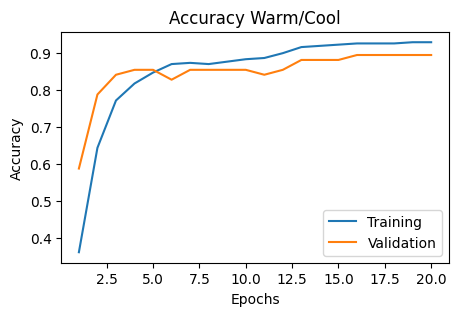

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(range(1, len(avg_train_acc) + 1), avg_train_acc)
plt.plot(range(1, len(avg_val_acc) + 1), avg_val_acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Warm/Cool')
plt.legend(['Training', 'Validation'])
plt.show()

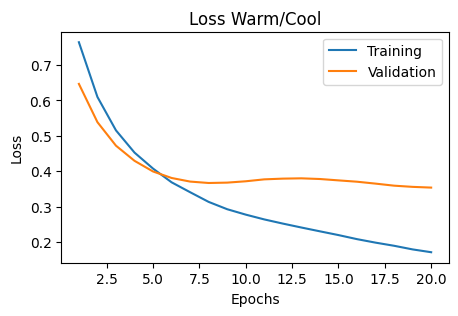

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(range(1, len(avg_train_loss) + 1), avg_train_loss)
plt.plot(range(1, len(avg_val_loss)+ 1), avg_val_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Warm/Cool')
plt.legend(['Training', 'Validation'])
plt.show()

In [ ]:
model = build_model()
model.fit(X_train, y_train, epochs=10, verbose=0)
test_acc, test_loss = model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 108ms/step - loss: 0.3373 - accuracy: 1.0000


In [ ]:
warm_ = warm.copy()
warm_['label'] = warm_['label'].apply(lambda x: 0 if x == 'spring' else 1)
cool_ = cool.copy()
cool_['label'] = cool_['label'].apply(lambda x:  0 if x == 'summer' else 1)

### warm only

In [ ]:
warm_.sample(frac=1, random_state=42).reset_index(drop=True)
X_train_full = warm_.iloc[:, :-1]
y_train_full = warm_['label']

In [ ]:
warm_.head()

,lips_s,face_l_var,skin_avg_b,R,G,B,H,S,V,L,a,b,label
0,151.666667,0.000008,145.8,112.914310,133.965925,175.651445,9.75,105.75,165.50,139.25,141.50,145.25,1
1,150.000000,0.000025,146.3,126.187999,147.715856,191.952797,8.25,99.50,181.00,152.50,142.75,144.50,0
2,154.000000,0.000012,141.8,112.976115,125.444865,172.908069,5.25,107.25,157.75,127.75,144.50,140.50,0
3,152.333333,0.000009,145.1,105.951249,125.220850,170.398417,8.75,115.50,163.75,134.25,143.00,145.00,1
4,151.666667,0.000015,145.2,108.123511,128.183753,173.363279,8.50,115.75,167.00,136.25,143.50,145.25,0


In [ ]:
X_train_full.shape

(89, 12)

In [ ]:
test_size = int(len(X_train_full) * .1)
test_size

8

In [ ]:
X_train = X_train_full[test_size:].to_numpy()
y_train = y_train_full[test_size:].to_numpy()
X_test = X_train_full[:test_size].to_numpy()
y_test = y_train_full[:test_size].to_numpy()

In [ ]:
X_train.shape

(81, 12)

In [ ]:
X_train = np.copy(X_train)
mean = X_train.mean(axis=0)
X_train -= mean
std = X_train.std(axis=0)
X_train /= std

X_test = np.copy(X_test)
X_test -= mean
X_test /= std

In [ ]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

lr_schedule = ExponentialDecay(
    0.01,
    decay_steps=5,
    decay_rate=0.8,
    staircase=True)

In [ ]:
def build_model():
    model = keras.models.Sequential()
    model.add(layers.Flatten(input_shape=(X_train.shape[1],)))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=lr_schedule), metrics=['accuracy'])
    return model

In [ ]:
k = 5
n = len(X_train)
n_val = n // k
num_epochs = 30
all_val_losses = []
all_train_losses = []
all_train_acc = []
all_val_acc = []

for i in range(k):
  print('processing fold #', i)
  val_data = X_train[i * n_val: (i + 1) * n_val]
  val_targets = y_train[i * n_val: (i + 1) * n_val]
  X_train_part = np.concatenate([X_train[:i * n_val], X_train[(i + 1) * n_val:]], axis=0)
  y_train_part = np.concatenate([y_train[:i * n_val], y_train[(i + 1) * n_val:]], axis=0)
  model = build_model()
  history = model.fit(X_train_part, y_train_part, validation_data=(val_data, val_targets),
                      epochs=num_epochs)
  val_history = history.history['val_loss']
  train_history = history.history['loss']
  val_acc = history.history['val_accuracy']
  train_acc = history.history['accuracy']
  all_train_losses.append(train_history)
  all_val_losses.append(val_history)
  all_train_acc.append(train_acc)
  all_val_acc.append(val_acc)

processing fold # 0
Epoch 1/30
3/3 [==============================] - 1s 96ms/step - loss: 0.8018 - accuracy: 0.2462 - val_loss: 0.5997 - val_accuracy: 0.7500
Epoch 2/30
3/3 [==============================] - 0s 13ms/step - loss: 0.5839 - accuracy: 0.7385 - val_loss: 0.5086 - val_accuracy: 0.7500
Epoch 3/30
3/3 [==============================] - 0s 14ms/step - loss: 0.4788 - accuracy: 0.8615 - val_loss: 0.4526 - val_accuracy: 0.8125
Epoch 4/30
3/3 [==============================] - 0s 14ms/step - loss: 0.4178 - accuracy: 0.8923 - val_loss: 0.4242 - val_accuracy: 0.8125
Epoch 5/30
3/3 [==============================] - 0s 14ms/step - loss: 0.3838 - accuracy: 0.8769 - val_loss: 0.4055 - val_accuracy: 0.8125
Epoch 6/30
3/3 [==============================] - 0s 14ms/step - loss: 0.3611 - accuracy: 0.8769 - val_loss: 0.3928 - val_accuracy: 0.8125
Epoch 7/30
3/3 [==============================] - 0s 14ms/step - loss: 0.3466 - accuracy: 0.8769 - val_loss: 0.3846 - val_accuracy: 0.8125
Epoch 8

In [ ]:
avg_val_loss = [np.mean([x[i] for x in all_val_losses]) for i in range(num_epochs)]
avg_train_loss = [np.mean([x[i] for x in all_train_losses]) for i in range(num_epochs)]
avg_val_acc = [np.mean([x[i] for x in all_val_acc]) for i in range(num_epochs)]
avg_train_acc = [np.mean([x[i] for x in all_train_acc]) for i in range(num_epochs)]

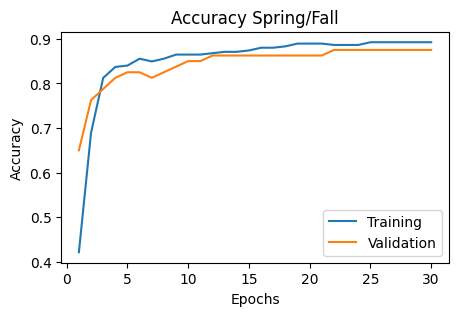

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(range(1, len(avg_train_acc) + 1), avg_train_acc)
plt.plot(range(1, len(avg_val_acc) + 1), avg_val_acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Spring/Fall')
plt.legend(['Training', 'Validation'])
plt.show()

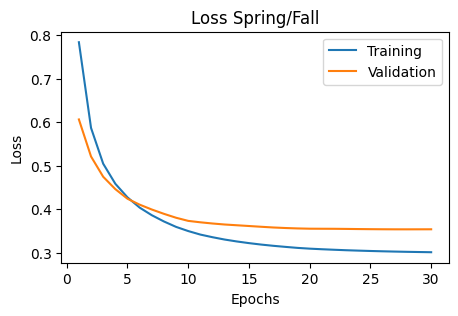

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(range(1, len(avg_train_loss) + 1), avg_train_loss)
plt.plot(range(1, len(avg_val_loss)+ 1), avg_val_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Spring/Fall')
plt.legend(['Training', 'Validation'])
plt.show()

In [ ]:
model = build_model()
model.fit(X_train, y_train, epochs=10, verbose=0)
test_acc, test_loss = model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 113ms/step - loss: 0.4186 - accuracy: 0.7500


### cool only

In [ ]:
cool_.sample(frac=1, random_state=42).reset_index(drop=True)
X_train_full = cool_.iloc[:, :-1]
y_train_full = cool_['label']

In [ ]:
X_train_full.shape

(99, 12)

In [ ]:
test_size = int(len(X_train_full) * .15)
test_size

14

In [ ]:
X_train = X_train_full[test_size:].to_numpy()
y_train = y_train_full[test_size:].to_numpy()
X_test = X_train_full[:test_size].to_numpy()
y_test = y_train_full[:test_size].to_numpy()

In [ ]:
X_train = np.copy(X_train)
mean = X_train.mean(axis=0)
X_train -= mean
std = X_train.std(axis=0)
X_train /= std

X_test = np.copy(X_test)
X_test -= mean
X_test /= std

In [ ]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

lr_schedule = ExponentialDecay(
    0.001,
    decay_steps=20,
    decay_rate=0.9,
    staircase=True)

In [ ]:
def build_model():
    model = keras.models.Sequential()
    model.add(layers.Flatten(input_shape=(X_train.shape[1],)))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(8, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

In [ ]:
k = 5
n = len(X_train)
n_val = n // k
num_epochs = 20
all_val_losses = []
all_train_losses = []
all_train_acc = []
all_val_acc = []

for i in range(k):
  print('processing fold #', i)
  val_data = X_train[i * n_val: (i + 1) * n_val]
  val_targets = y_train[i * n_val: (i + 1) * n_val]
  X_train_part = np.concatenate([X_train[:i * n_val], X_train[(i + 1) * n_val:]], axis=0)
  y_train_part = np.concatenate([y_train[:i * n_val], y_train[(i + 1) * n_val:]], axis=0)
  model = build_model()
  history = model.fit(X_train_part, y_train_part, validation_data=(val_data, val_targets), epochs=num_epochs)
  val_history = history.history['val_loss']
  train_history = history.history['loss']
  val_acc = history.history['val_accuracy']
  train_acc = history.history['accuracy']
  all_train_losses.append(train_history)
  all_val_losses.append(val_history)
  all_train_acc.append(train_acc)
  all_val_acc.append(val_acc)

processing fold # 0
Epoch 1/20
3/3 [==============================] - 1s 108ms/step - loss: 0.7941 - accuracy: 0.4265 - val_loss: 0.7233 - val_accuracy: 0.4118
Epoch 2/20
3/3 [==============================] - 0s 30ms/step - loss: 0.7782 - accuracy: 0.4265 - val_loss: 0.7192 - val_accuracy: 0.4118
Epoch 3/20
3/3 [==============================] - 0s 27ms/step - loss: 0.7650 - accuracy: 0.4559 - val_loss: 0.7155 - val_accuracy: 0.4118
Epoch 4/20
3/3 [==============================] - 0s 17ms/step - loss: 0.7552 - accuracy: 0.4706 - val_loss: 0.7119 - val_accuracy: 0.3529
Epoch 5/20
3/3 [==============================] - 0s 17ms/step - loss: 0.7449 - accuracy: 0.4706 - val_loss: 0.7092 - val_accuracy: 0.3529
Epoch 6/20
3/3 [==============================] - 0s 17ms/step - loss: 0.7364 - accuracy: 0.4706 - val_loss: 0.7072 - val_accuracy: 0.3529
Epoch 7/20
3/3 [==============================] - 0s 16ms/step - loss: 0.7287 - accuracy: 0.4706 - val_loss: 0.7060 - val_accuracy: 0.3529
Epoch 

In [ ]:
avg_val_loss = [np.mean([x[i] for x in all_val_losses]) for i in range(num_epochs)]
avg_train_loss = [np.mean([x[i] for x in all_train_losses]) for i in range(num_epochs)]
avg_val_acc = [np.mean([x[i] for x in all_val_acc]) for i in range(num_epochs)]
avg_train_acc = [np.mean([x[i] for x in all_train_acc]) for i in range(num_epochs)]

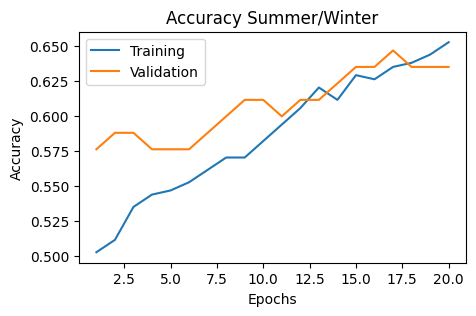

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(range(1, len(avg_train_acc) + 1), avg_train_acc)
plt.plot(range(1, len(avg_val_acc) + 1), avg_val_acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Summer/Winter')
plt.legend(['Training', 'Validation'])
plt.show()

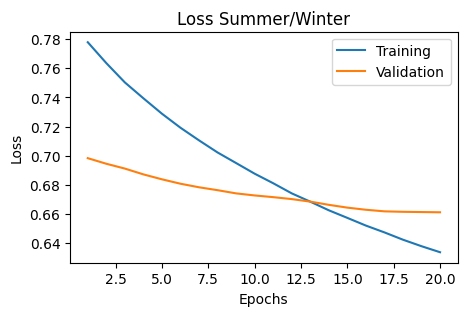

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(range(1, len(avg_train_loss) + 1), avg_train_loss)
plt.plot(range(1, len(avg_val_loss)+ 1), avg_val_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Summer/Winter')
plt.legend(['Training', 'Validation'])
plt.show()

In [ ]:
avg_train_loss[-1]

0.6336442589759826

In [ ]:
avg_val_loss[-1]

0.6610906600952149

In [ ]:
model = build_model()
model.fit(X_train, y_train, epochs=10, verbose=0)
test_acc, test_loss = model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 106ms/step - loss: 0.6955 - accuracy: 0.6429


In [ ]:
def build_model():
    model = keras.models.Sequential()
    model.add(layers.Flatten(input_shape=(X_train.shape[1],)))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

In [ ]:
k = 5
n = len(X_train)
n_val = n // k
num_epochs = 20
all_val_losses = []
all_train_losses = []
all_train_acc = []
all_val_acc = []

for i in range(k):
  print('processing fold #', i)
  val_data = X_train[i * n_val: (i + 1) * n_val]
  val_targets = y_train[i * n_val: (i + 1) * n_val]
  X_train_part = np.concatenate([X_train[:i * n_val], X_train[(i + 1) * n_val:]], axis=0)
  y_train_part = np.concatenate([y_train[:i * n_val], y_train[(i + 1) * n_val:]], axis=0)
  model = build_model()
  history = model.fit(X_train_part, y_train_part, validation_data=(val_data, val_targets), epochs=num_epochs)
  val_history = history.history['val_loss']
  train_history = history.history['loss']
  val_acc = history.history['val_accuracy']
  train_acc = history.history['accuracy']
  all_train_losses.append(train_history)
  all_val_losses.append(val_history)
  all_train_acc.append(train_acc)
  all_val_acc.append(val_acc)

processing fold # 0
Epoch 1/20
3/3 [==============================] - 1s 129ms/step - loss: 0.7138 - accuracy: 0.5147 - val_loss: 0.7540 - val_accuracy: 0.5882
Epoch 2/20
3/3 [==============================] - 0s 44ms/step - loss: 0.6963 - accuracy: 0.5147 - val_loss: 0.7523 - val_accuracy: 0.5294
Epoch 3/20
3/3 [==============================] - 0s 28ms/step - loss: 0.6840 - accuracy: 0.5441 - val_loss: 0.7532 - val_accuracy: 0.5294
Epoch 4/20
3/3 [==============================] - 0s 27ms/step - loss: 0.6725 - accuracy: 0.5588 - val_loss: 0.7551 - val_accuracy: 0.5882
Epoch 5/20
3/3 [==============================] - 0s 40ms/step - loss: 0.6612 - accuracy: 0.5882 - val_loss: 0.7572 - val_accuracy: 0.5882
Epoch 6/20
3/3 [==============================] - 0s 22ms/step - loss: 0.6508 - accuracy: 0.6471 - val_loss: 0.7589 - val_accuracy: 0.5294
Epoch 7/20
3/3 [==============================] - 0s 30ms/step - loss: 0.6427 - accuracy: 0.6471 - val_loss: 0.7612 - val_accuracy: 0.5294
Epoch 

In [ ]:
avg_val_loss = [np.mean([x[i] for x in all_val_losses]) for i in range(num_epochs)]
avg_train_loss = [np.mean([x[i] for x in all_train_losses]) for i in range(num_epochs)]
avg_val_acc = [np.mean([x[i] for x in all_val_acc]) for i in range(num_epochs)]
avg_train_acc = [np.mean([x[i] for x in all_train_acc]) for i in range(num_epochs)]

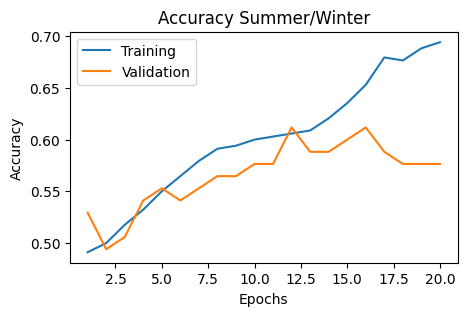

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(range(1, len(avg_train_acc) + 1), avg_train_acc)
plt.plot(range(1, len(avg_val_acc) + 1), avg_val_acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Summer/Winter')
plt.legend(['Training', 'Validation'])
plt.show()

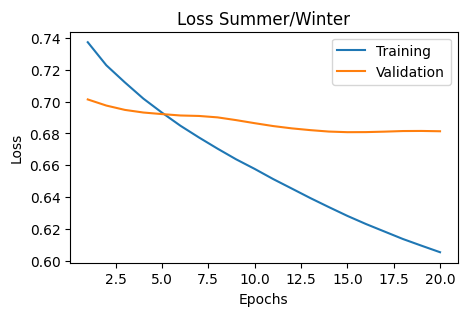

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(range(1, len(avg_train_loss) + 1), avg_train_loss)
plt.plot(range(1, len(avg_val_loss)+ 1), avg_val_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Summer/Winter')
plt.legend(['Training', 'Validation'])
plt.show()

In [ ]:
model = build_model()
model.fit(X_train, y_train, epochs=10, verbose=0)
test_acc, test_loss = model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 131ms/step - loss: 0.6891 - accuracy: 0.5000


### all

In [ ]:
all = pd.read_csv(os.path.join(data_root, 'mean_shuffled.csv'))

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
all['label'] = le.fit_transform(all['label'])

In [ ]:
all.sample(frac=1, random_state=42).reset_index(drop=True)
X_train_full = all.iloc[:, :-1]
y_train_full = all['label']

In [ ]:
X_train_full.shape

(188, 12)

In [ ]:
test_size = int(len(X_train_full) * .1)
test_size

18

In [ ]:
X_train = X_train_full[test_size:].to_numpy()
y_train = y_train_full[test_size:].to_numpy()
X_test = X_train_full[:test_size].to_numpy()
y_test = y_train_full[:test_size].to_numpy()

In [ ]:
X_train = np.copy(X_train)
mean = X_train.mean(axis=0)
X_train -= mean
std = X_train.std(axis=0)
X_train /= std

X_test = np.copy(X_test)
X_test -= mean
X_test /= std

In [ ]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

lr_schedule = ExponentialDecay(
    0.001,
    decay_steps=20,
    decay_rate=0.9,
    staircase=True)

In [ ]:
y_test

array([0, 3, 1, 2, 1, 0, 3, 2, 1, 2, 0, 1, 3, 0, 0, 1, 0, 1])

In [ ]:
def build_model():
    model = keras.models.Sequential()
    model.add(layers.Flatten(input_shape=(X_train.shape[1],)))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(4, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

In [ ]:
k = 5
n = len(X_train)
n_val = n // k
num_epochs = 20
all_train_losses = []
all_train_acc = []

for i in range(k):
  print('processing fold #', i)
  model = build_model()
  history = model.fit(X_train, y_train, epochs=num_epochs)
  train_history = history.history['loss']
  train_acc = history.history['accuracy']
  all_train_losses.append(train_history)
  all_train_acc.append(train_acc)

processing fold # 0
Epoch 1/20
6/6 [==============================] - 1s 2ms/step - loss: 1.5476 - accuracy: 0.2412
Epoch 2/20
6/6 [==============================] - 0s 2ms/step - loss: 1.4843 - accuracy: 0.2765
Epoch 3/20
6/6 [==============================] - 0s 3ms/step - loss: 1.4269 - accuracy: 0.2824
Epoch 4/20
6/6 [==============================] - 0s 2ms/step - loss: 1.3791 - accuracy: 0.3059
Epoch 5/20
6/6 [==============================] - 0s 2ms/step - loss: 1.3314 - accuracy: 0.3353
Epoch 6/20
6/6 [==============================] - 0s 2ms/step - loss: 1.2854 - accuracy: 0.3824
Epoch 7/20
6/6 [==============================] - 0s 2ms/step - loss: 1.2412 - accuracy: 0.4471
Epoch 8/20
6/6 [==============================] - 0s 2ms/step - loss: 1.1982 - accuracy: 0.4529
Epoch 9/20
6/6 [==============================] - 0s 2ms/step - loss: 1.1575 - accuracy: 0.4765
Epoch 10/20
6/6 [==============================] - 0s 3ms/step - loss: 1.1145 - accuracy: 0.5176
Epoch 11/20
6/6 [==

In [ ]:
model = build_model()
model.fit(X_train, y_train, epochs=10, verbose=0)
test_acc, test_loss = model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 104ms/step - loss: 1.2581 - accuracy: 0.5000
